<a href="https://colab.research.google.com/github/Raaghashree/Intel-Products-Sentiment-Analysis/blob/main/ML_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
torch.cuda.is_available()

True

In [1]:
!pip install datasets transformers huggingface_hub

In [3]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [4]:
from datasets import load_dataset
imdb = load_dataset("imdb")
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [5]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}


In [7]:
from huggingface_hub import notebook_login
notebook_login()


In [8]:
!pip install torch


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [18]:
!pip install accelerate -U
!pip install transformers[torch] -U


In [20]:
from transformers import TrainingArguments, Trainer

repo_name = "finetuning-sentiment-model-3000-samples"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


In [21]:
trainer.train()


Step,Training Loss


TrainOutput(global_step=376, training_loss=0.30110574275889296, metrics={'train_runtime': 302.1825, 'train_samples_per_second': 19.856, 'train_steps_per_second': 1.244, 'total_flos': 782725021021056.0, 'train_loss': 0.30110574275889296, 'epoch': 2.0})

In [22]:
trainer.evaluate()


<ipython-input-15-b1430cee0b64>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


{'eval_loss': 0.3272470235824585,
 'eval_accuracy': 0.8633333333333333,
 'eval_f1': 0.8637873754152824,
 'eval_runtime': 42.4653,
 'eval_samples_per_second': 7.065,
 'eval_steps_per_second': 0.447,
 'epoch': 2.0}

In [23]:
trainer.push_to_hub()


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1720352991.fd33ea5d657d.3414.1:   0%|          | 0.00/457 [00:00<?, ?B/s]

events.out.tfevents.1720352624.fd33ea5d657d.3414.0:   0%|          | 0.00/5.13k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Raagha/finetuning-sentiment-model-3000-samples/commit/14e5d2762d8b3339eb83913f85159c2146f04734', commit_message='End of training', commit_description='', oid='14e5d2762d8b3339eb83913f85159c2146f04734', pr_url=None, pr_revision=None, pr_num=None)

MODEL:

In [1]:
from transformers import pipeline

sentiment_model = pipeline(model="Raagha/finetuning-sentiment-model-3000-samples")
sentiment_model(["I love this move", "This movie sucks!"])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[{'label': 'LABEL_1', 'score': 0.9559447169303894},
 {'label': 'LABEL_0', 'score': 0.9681430459022522}]

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Intel 14th gen data.csv to Intel 14th gen data.csv


In [3]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize NLTK components
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words.update(['cpu','good','processor','intel','chip','gen','run','pc','used','return','box','new','amazon','issue','day',"don't",'open','great','open','core','got','im','fine','like','didnt','tried','despite','month','case','high'])

# Function to preprocess the DataFrame
def preprocessing(df):
    """
    Preprocess the DataFrame by dropping duplicates, handling NaN values in 'reviewDescription',
    converting text to lowercase, removing stop words, and lemmatizing.
    """
    df.drop_duplicates(subset='reviewId', keep='first', inplace=True)
    df['reviewDescription'].fillna('', inplace=True)
    df['reviewDescription'] = df['reviewDescription'].astype(str).str.lower()

    def clean_text(text):
        text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
        words = nltk.word_tokenize(text)
        words = [word for word in words if word.isalpha()]  # Remove non-alphabetic tokens
        words = [word for word in words if word not in stop_words]  # Remove stop words
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized_words)

    df['reviewDescription'] = df['reviewDescription'].apply(clean_text)
    return df

# Load your custom CSV file into a DataFrame
df = pd.read_csv("Intel 13th gen data.csv")

# Preprocess the DataFrame
df = preprocessing(df)
print("After preprocessing:", df.shape)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


After preprocessing: (993, 7)


In [4]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['reviewDescription'], df['sentiment_binary'], test_size=0.2, random_state=42)

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

NameError: name 'train_test_split' is not defined

In [5]:
def analyze_sentiment(review):
    try:
        result = sentiment_model(review)[0]
        return result['label'], result['score']
    except Exception as e:
        print(f"Error processing review: {review[:50]}... | Error: {e}")
        return None, None

# Apply sentiment analysis to the DataFrame
df[['sentiment', 'score']] = df['reviewDescription'].apply(lambda x: pd.Series(analyze_sentiment(x)))

# Filter out rows where sentiment analysis failed
df = df.dropna(subset=['sentiment', 'score'])

# Convert sentiment labels to binary
df['sentiment_binary'] = df['sentiment'].apply(lambda x: 'positive' if x == 'LABEL_1' else 'negative')


Token indices sequence length is longer than the specified maximum sequence length for this model (718 > 512). Running this sequence through the model will result in indexing errors


Error processing review: general mentioned review product described working... | Error: The size of tensor a (718) must match the size of tensor b (512) at non-singleton dimension 1
Error processing review: die probleme haben direkt ersten tag angefangenwin... | Error: The size of tensor a (551) must match the size of tensor b (512) at non-singleton dimension 1
Error processing review: il miglior processore nel per chi vuole sia videog... | Error: The size of tensor a (804) must match the size of tensor b (512) at non-singleton dimension 1
Error processing review: ich wusste ja worauf ich mich einlasse der ist ein... | Error: The size of tensor a (766) must match the size of tensor b (512) at non-singleton dimension 1
Error processing review: acquistato durante il prime questo processore port... | Error: The size of tensor a (529) must match the size of tensor b (512) at non-singleton dimension 1
Error processing review: habe mir einen neuen gebaut und e war definitiv di... | Error: Th

<ipython-input-5-cd044a3d8e8f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_binary'] = df['sentiment'].apply(lambda x: 'positive' if x == 'LABEL_1' else 'negative')


In [6]:
df.head()

,Id,reviewId,country,ratingScore,productAsin,reviewTitle,reviewDescription,sentiment,score,sentiment_binary
0,1,R140DFFKFTKG4K,India,5,B0BCF57FL5,Nice,,LABEL_0,0.506557,negative
1,2,RAM3AEE79280Q,India,5,B0BCF57FL5,Go for it..,absolutely incredible doubt keep mind go atlea...,LABEL_1,0.680114,positive
2,3,R3U6BJHPT28XMP,India,5,B0BCF57FL5,Best cpu at this price bracket,powerful price bracket doubt amazing performan...,LABEL_1,0.810242,positive
3,4,RU7YX4667K3DK,India,5,B0BCF57FL5,Just bought it! and working great except the t...,best buy far gaming editing run whatever throw...,LABEL_1,0.681992,positive
4,5,REI2D2XR93GT,United States,5,B0BCF57FL5,No need for undervolt,temp idle load low radiator,LABEL_0,0.587331,negative


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.feature_extraction.text import TfidfVectorizer


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['reviewDescription'], df['sentiment_binary'], test_size=0.2, random_state=42)

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [8]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)


LogisticRegression()

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='positive')
recall = recall_score(y_test, y_pred, pos_label='positive')
f1 = f1_score(y_test, y_pred, pos_label='positive')

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.7614213197969543
Precision: 0.7575757575757576
Recall: 0.946969696969697
F1 Score: 0.8417508417508418


TypeError: unsupported operand type(s) for +: 'int' and 'function'

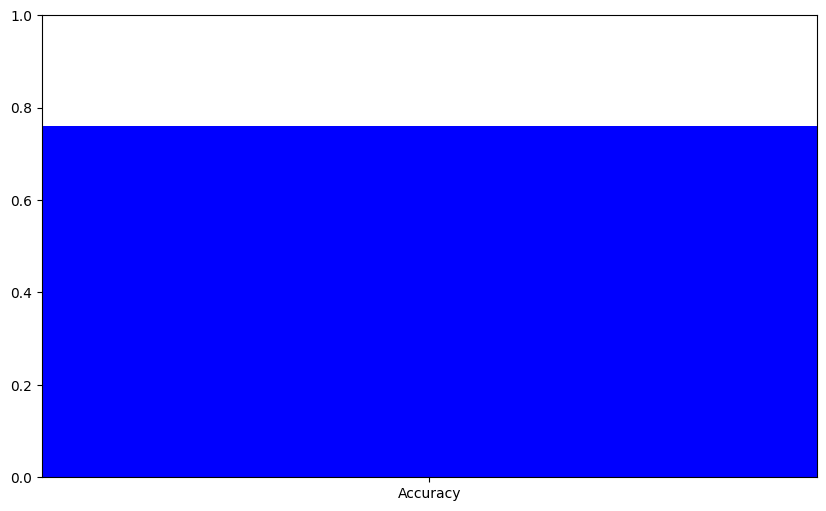

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and their values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1_score]

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])

# Adding text annotations to each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points", ha='center', va='bottom')

# Set title and labels
ax.set_title('Model Performance Metrics')
ax.set_ylim(0, 1)  # Set y-axis limit to 1 as these are percentage values
ax.set_ylabel('Score')
ax.set_xlabel('Metrics')

# Show the plot
plt.show()


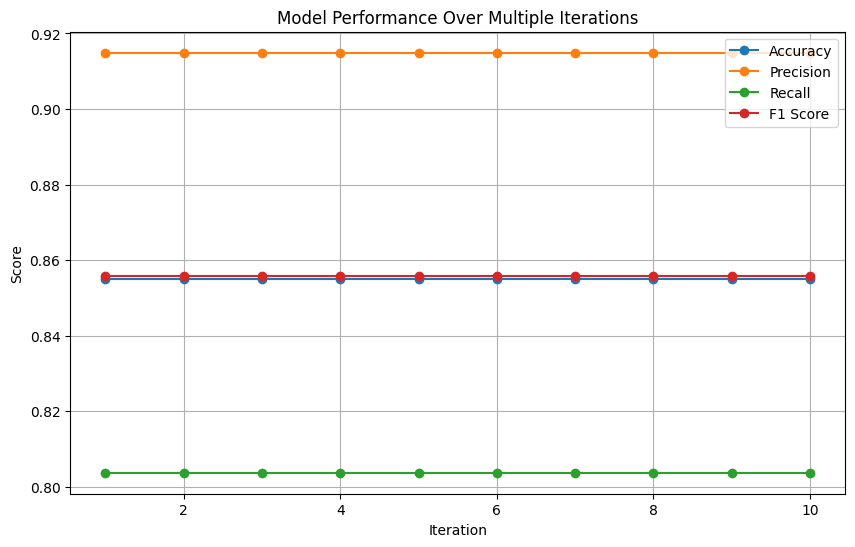

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# Generate a sample dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize arrays to store metrics
num_iterations = 10
accuracy_scores = np.zeros(num_iterations)
precision_scores = np.zeros(num_iterations)
recall_scores = np.zeros(num_iterations)
f1_scores = np.zeros(num_iterations)

# Train and evaluate the model multiple times
for i in range(num_iterations):
    # Initialize the model
    model = LogisticRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Compute metrics
    accuracy_scores[i] = accuracy_score(y_test, y_pred)
    precision_scores[i] = precision_score(y_test, y_pred)
    recall_scores[i] = recall_score(y_test, y_pred)
    f1_scores[i] = f1_score(y_test, y_pred)

# Plot the metrics
iterations = np.arange(1, num_iterations + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, accuracy_scores, label='Accuracy', marker='o')
plt.plot(iterations, precision_scores, label='Precision', marker='o')
plt.plot(iterations, recall_scores, label='Recall', marker='o')
plt.plot(iterations, f1_scores, label='F1 Score', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('Model Performance Over Multiple Iterations')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

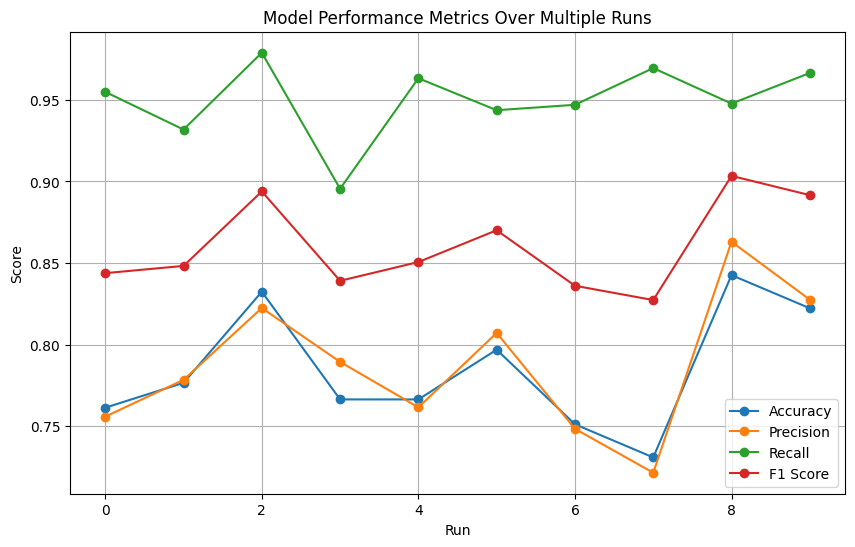

Average Accuracy: 0.7847715736040608
Average Precision: 0.7876024455655797
Average Recall: 0.9498589010453695
Average F1 Score: 0.8604510040854221


In [12]:
X = df['reviewDescription']
y = df['sentiment_binary']  # Assuming this column contains the sentiment labels

# Initialize arrays to store metrics
num_runs = 10  # Number of times to train and test the model
accuracies = np.zeros(num_runs)
precisions = np.zeros(num_runs)
recalls = np.zeros(num_runs)
f1_scores = np.zeros(num_runs)

# Run multiple training sessions
for i in range(num_runs):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Convert text data to TF-IDF features
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Initialize and train the logistic regression model
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    # Predict on test set
    y_pred = model.predict(X_test_tfidf)

    # Calculate metrics
    accuracies[i] = accuracy_score(y_test, y_pred)
    precisions[i] = precision_score(y_test, y_pred, pos_label='positive')
    recalls[i] = recall_score(y_test, y_pred, pos_label='positive')
    f1_scores[i] = f1_score(y_test, y_pred, pos_label='positive')

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(range(num_runs), accuracies, label='Accuracy', marker='o')
plt.plot(range(num_runs), precisions, label='Precision', marker='o')
plt.plot(range(num_runs), recalls, label='Recall', marker='o')
plt.plot(range(num_runs), f1_scores, label='F1 Score', marker='o')

plt.xlabel('Run')
plt.ylabel('Score')
plt.title('Model Performance Metrics Over Multiple Runs')
plt.legend()
plt.grid(True)
plt.show()

# Print average metrics
print(f"Average Accuracy: {np.mean(accuracies)}")
print(f"Average Precision: {np.mean(precisions)}")
print(f"Average Recall: {np.mean(recalls)}")
print(f"Average F1 Score: {np.mean(f1_scores)}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

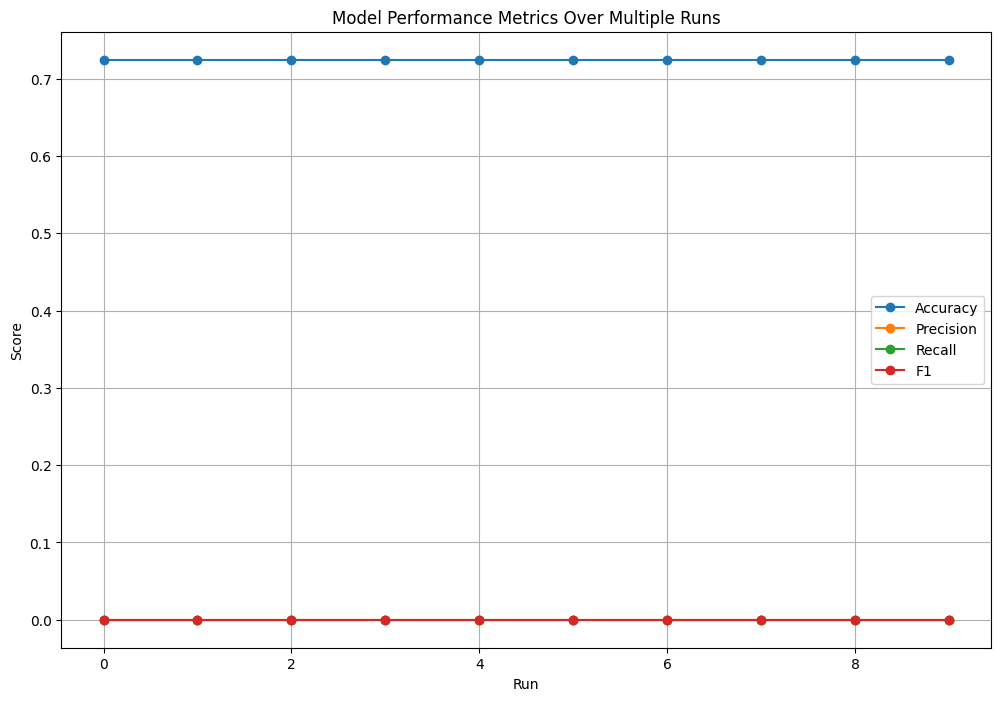

In [17]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Load and preprocess your data
df = pd.read_csv("Intel 14th gen data.csv")

# Preprocess the DataFrame
df = preprocessing(df)

def classify_sentiment(text):
    try:
        result = sentiment_model(text)[0]
        label = result['label']
        score = result['score']
        sentiment_binary = 'positive' if label == 'LABEL_1' else 'negative'
        return sentiment_binary
    except Exception as e:
        print(f"Error processing text: {text}\n{e}")
        return None

# Apply the function to create the 'sentiment_binary' column
df['sentiment_binary'] = df['reviewDescription'].apply(classify_sentiment)

# Drop rows where sentiment_binary could not be determined (None values)
df = df.dropna(subset=['sentiment_binary'])

# Vectorize the text data
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['reviewDescription'])
y = df['sentiment_binary']


# Define the model and scoring
model = LogisticRegression()
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label='positive'),
    'recall': make_scorer(recall_score, pos_label='positive'),
    'f1': make_scorer(f1_score, pos_label='positive')
}

# Perform multiple runs of cross-validation
n_runs = 10
metrics_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for run in range(n_runs):
    scores = cross_validate(model, X, y, cv=skf, scoring=scoring)
    for metric in scoring.keys():
        metrics_results[metric].append(np.mean(scores['test_' + metric]))

# Plot the results
plt.figure(figsize=(12, 8))

for metric, values in metrics_results.items():
    plt.plot(range(n_runs), values, marker='o', label=metric.capitalize())

plt.xlabel('Run')
plt.ylabel('Score')
plt.title('Model Performance Metrics Over Multiple Runs')
plt.legend()
plt.grid(True)
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Epoch 1/10
3/3 [==============================] - 4s 106ms/step - loss: 0.6839 - accuracy: 0.6092 - val_loss: 0.6738 - val_accuracy: 0.6364
Epoch 2/10
3/3 [==============================] - 0s 17ms/step - loss: 0.6363 - accuracy: 0.7356 - val_loss: 0.6534 - val_accuracy: 0.6364
Epoch 3/10
3/3 [==============================] - 0s 15ms/step - loss: 0.5896 - accuracy: 0.7011 - val_loss: 0.6364 - val_accuracy: 0.6364
Epoch 4/10
3/3 [==============================] - 0s 16ms/step - loss: 0.5411 - accuracy: 0.7126 - val_loss: 0.6216 - val_accuracy: 0.6364
Epoch 5/10
3/3 [==============================] - 0s 17ms/step - loss: 0.5017 - accuracy: 0.7011 - val_loss: 0.6088 - val_accuracy: 0.6364
Epoch 6/10
3/3 [==============================] - 0s 17ms/step - loss: 0.4663 - accuracy: 0.7126 - val_loss: 0.5984 - val_accuracy: 0.6364
Epoch 7/10
3/3 [==============================] - 0s 15ms/step - loss: 0.4343 - accuracy: 0.7126 - val_loss: 0.5906 - val_accuracy: 0.6364
Epoch 8/10
3/3 [==========

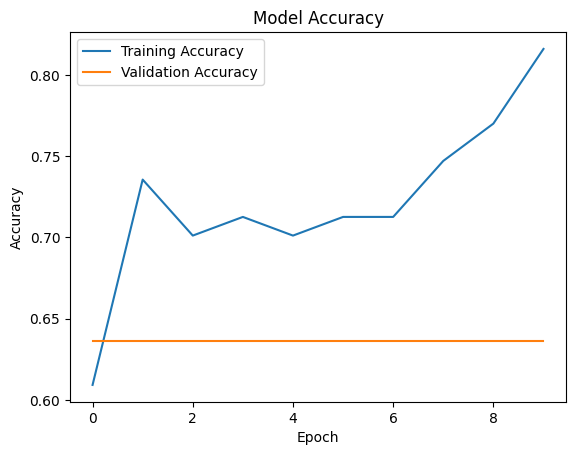

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import pipeline

# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize NLTK components
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words.update(['cpu', 'good', 'processor', 'intel', 'chip', 'gen', 'run', 'pc', 'used', 'return', 'box', 'new', 'amazon', 'issue', 'day', "don't", 'open', 'great', 'open', 'core', 'got', 'im', 'fine', 'like', 'didnt', 'tried', 'despite', 'month', 'case', 'high'])

# Initialize sentiment analysis model
sentiment_model = pipeline("sentiment-analysis")

# Function to preprocess the DataFrame
def preprocessing(df):
    """
    Preprocess the DataFrame by dropping duplicates, handling NaN values in 'reviewDescription',
    converting text to lowercase, removing stop words, and lemmatizing.
    """
    df.drop_duplicates(subset='reviewId', keep='first', inplace=True)
    df['reviewDescription'].fillna('', inplace=True)
    df['reviewDescription'] = df['reviewDescription'].astype(str).str.lower()

    def clean_text(text):
        text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
        words = nltk.word_tokenize(text)
        words = [word for word in words if word.isalpha()]  # Remove non-alphabetic tokens
        words = [word for word in words if word not in stop_words]  # Remove stop words
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized_words)

    df['reviewDescription'] = df['reviewDescription'].apply(clean_text)
    return df

# Load and preprocess data
df = pd.read_csv("Intel 14th gen data.csv")
df = preprocessing(df)

def classify_sentiment(text):
    try:
        result = sentiment_model(text)[0]
        label = result['label']
        score = result['score']
        sentiment_binary = 'positive' if label == 'POSITIVE' else 'negative'
        return sentiment_binary
    except Exception as e:
        print(f"Error processing text: {text}\n{e}")
        return None

# Apply the function to create the 'sentiment_binary' column
df['sentiment_binary'] = df['reviewDescription'].apply(classify_sentiment)

# Drop rows where sentiment_binary could not be determined (None values)
df = df.dropna(subset=['sentiment_binary'])

# Vectorize the text data
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['reviewDescription']).toarray()

# Encode the labels
df['sentiment_binary'] = df['sentiment_binary'].map({'positive': 1, 'negative': 0})
y = to_categorical(df['sentiment_binary'], num_classes=2)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Epoch 1/10
3/3 [==============================] - 3s 100ms/step - loss: 0.6884 - accuracy: 0.5632 - val_loss: 0.6755 - val_accuracy: 0.6364
Epoch 2/10
3/3 [==============================] - 0s 15ms/step - loss: 0.6342 - accuracy: 0.7126 - val_loss: 0.6572 - val_accuracy: 0.6364
Epoch 3/10
3/3 [==============================] - 0s 15ms/step - loss: 0.5872 - accuracy: 0.7126 - val_loss: 0.6406 - val_accuracy: 0.6364
Epoch 4/10
3/3 [==============================] - 0s 18ms/step - loss: 0.5426 - accuracy: 0.7011 - val_loss: 0.6256 - val_accuracy: 0.6364
Epoch 5/10
3/3 [==============================] - 0s 15ms/step - loss: 0.5015 - accuracy: 0.7011 - val_loss: 0.6129 - val_accuracy: 0.6364
Epoch 6/10
3/3 [==============================] - 0s 17ms/step - loss: 0.4687 - accuracy: 0.7011 - val_loss: 0.6032 - val_accuracy: 0.6364
Epoch 7/10
3/3 [==============================] - 0s 15ms/step - loss: 0.4267 - accuracy: 0.7241 - val_loss: 0.5956 - val_accuracy: 0.6364
Epoch 8/10
3/3 [==========

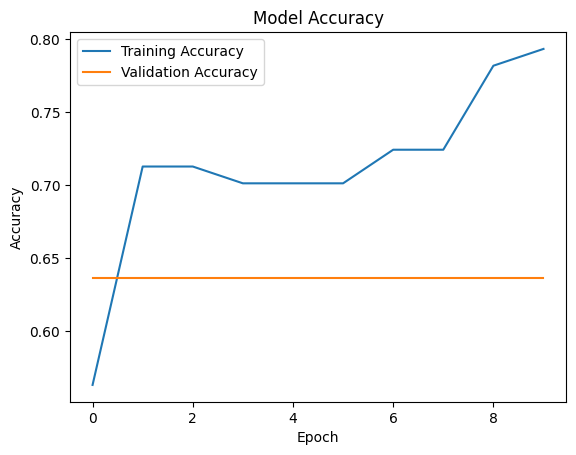

1/1 [==============================] - 0s 64ms/step
Precision: 0.4049586776859504
Recall: 0.6363636363636364
F1 Score: 0.494949494949495


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


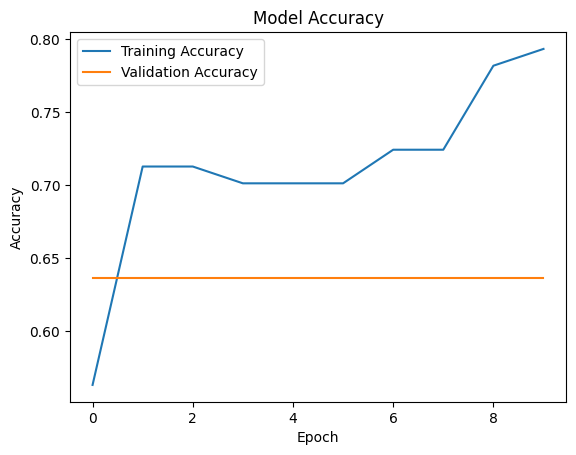

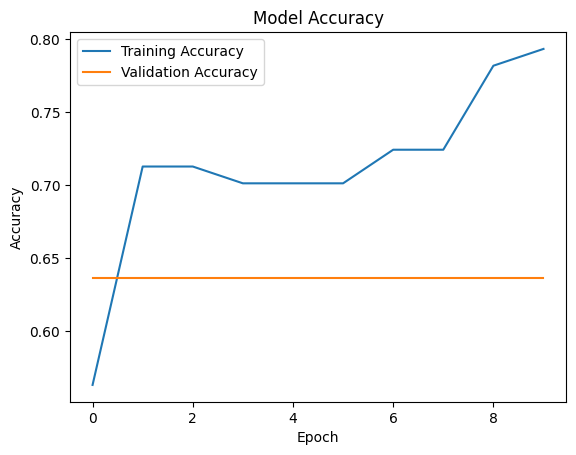

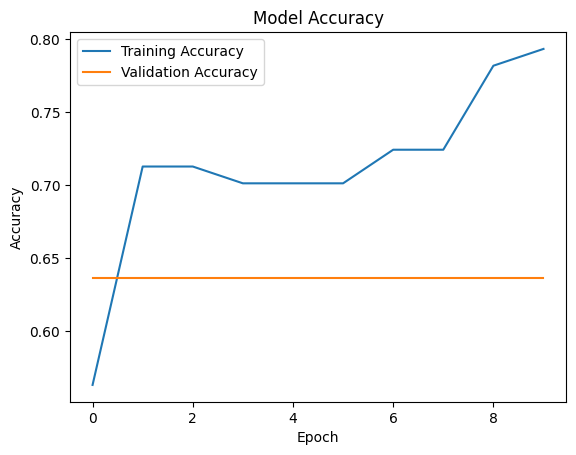

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import pipeline
from sklearn.metrics import precision_score, recall_score, f1_score

# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize NLTK components
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words.update(['cpu', 'good', 'processor', 'intel', 'chip', 'gen', 'run', 'pc', 'used', 'return', 'box', 'new', 'amazon', 'issue', 'day', "don't", 'open', 'great', 'open', 'core', 'got', 'im', 'fine', 'like', 'didnt', 'tried', 'despite', 'month', 'case', 'high'])

# Initialize sentiment analysis model
sentiment_model = pipeline("sentiment-analysis")

# Function to preprocess the DataFrame
def preprocessing(df):
    df.drop_duplicates(subset='reviewId', keep='first', inplace=True)
    df['reviewDescription'].fillna('', inplace=True)
    df['reviewDescription'] = df['reviewDescription'].astype(str).str.lower()

    def clean_text(text):
        text = text.translate(str.maketrans('', '', string.punctuation))
        words = nltk.word_tokenize(text)
        words = [word for word in words if word.isalpha()]
        words = [word for word in words if word not in stop_words]
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized_words)

    df['reviewDescription'] = df['reviewDescription'].apply(clean_text)
    return df

# Load and preprocess data
df = pd.read_csv("Intel 14th gen data.csv")
df = preprocessing(df)

def classify_sentiment(text):
    try:
        result = sentiment_model(text)[0]
        label = result['label']
        score = result['score']
        sentiment_binary = 'positive' if label == 'POSITIVE' else 'negative'
        return sentiment_binary
    except Exception as e:
        print(f"Error processing text: {text}\n{e}")
        return None

# Apply the function to create the 'sentiment_binary' column
df['sentiment_binary'] = df['reviewDescription'].apply(classify_sentiment)

# Drop rows where sentiment_binary could not be determined (None values)
df = df.dropna(subset=['sentiment_binary'])

# Vectorize the text data
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['reviewDescription']).toarray()

# Encode the labels
df['sentiment_binary'] = df['sentiment_binary'].map({'positive': 1, 'negative': 0})
y = to_categorical(df['sentiment_binary'], num_classes=2)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Plot precision
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot recall
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot F1 score
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
